In [1]:
from IPython.core.interactiveshell import InteractiveShell
import os
import sys
import gc
from time import time, sleep
from functools import partial
import pickle
from torch import multiprocessing as multiprocessing
import pixiedust as pxdb
import PIL
import cv2
from matplotlib import pyplot as plt
import seaborn as sns
from collections import OrderedDict as ODict
import numpy as np
from numba import jit
import pandas as pd
from sklearn.model_selection import train_test_split

# PYTORCH
import torch as tc
import torchvision as tcvis
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
from torch import nn, optim
from torch.nn import functional as fu
from torch.autograd import Variable
# TORCH HELPERS
import Augmentor
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.metrics import Accuracy, Loss
import hiddenlayer as hl
from torchsummary import summary
from tqdm import tqdm_notebook as tqdm

InteractiveShell.ast_node_interactivity = 'all'

# %pixie_debugger
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style='white', context='notebook', palette='tab10')
%config IPCompleter.greedy = True
%config IPCompleter.use_jedi = True


basepath = '/home/alk/Documents/Git/Kaggles/MNIST'
try:
    os.chdir(basepath)
    print(os.getcwd())
except NotADirectoryError:
    pass

Pixiedust database opened successfully


/home/alk/Documents/Git/Kaggles/MNIST


## Import Data and Split into sets and features

In [2]:
# run only when needed

datadir = os.getcwd() + '/data'
filenames = ['train.csv', 'test.csv']
datadict = ODict()
for files in filenames:
    try:
        with open(datadir + '/' + files, mode='r') as csvfile:
            datadict[files] = np.loadtxt(csvfile, delimiter=",", skiprows=1)
            csvfile.close()
        print('found file: {}'.format(files))
    except FileNotFoundError:
        print('skipping file ./{}'.format(files))

print(datadict.keys(), filenames)

found file: train.csv
found file: test.csv
odict_keys(['train.csv', 'test.csv']) ['train.csv', 'test.csv']


In [3]:
traindata = datadict[filenames[0]]
testdata = datadict[filenames[-1]]

trainlabels = traindata[:, 0].reshape(-1)
traindata = traindata[:, 1:].reshape(-1, 28, 28)
testdata = testdata.reshape(-1, 28, 28)
print(traindata.shape, trainlabels.shape, testdata.shape)

(42000, 28, 28) (42000,) (28000, 28, 28)


In [4]:
x_train, x_valid, y_train, y_valid = train_test_split(traindata, trainlabels, 
                                                      test_size=0.2)
x_test = testdata

for _ in [x_train, x_valid, y_train, y_valid, x_test]:
    print(f'Shape: {_.shape}')

Shape: (33600, 28, 28)
Shape: (8400, 28, 28)
Shape: (33600,)
Shape: (8400,)
Shape: (28000, 28, 28)


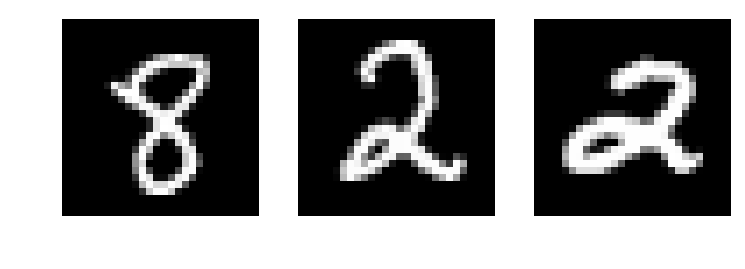

In [5]:
fig, ax = plt.subplots(1, 3, sharex=True, squeeze=True)
for _,x in zip(ax, [x_train, x_valid, x_test]):
    _.set_axis_off()
    __ = _.imshow(x[-1], cmap='gray');
plt.show()

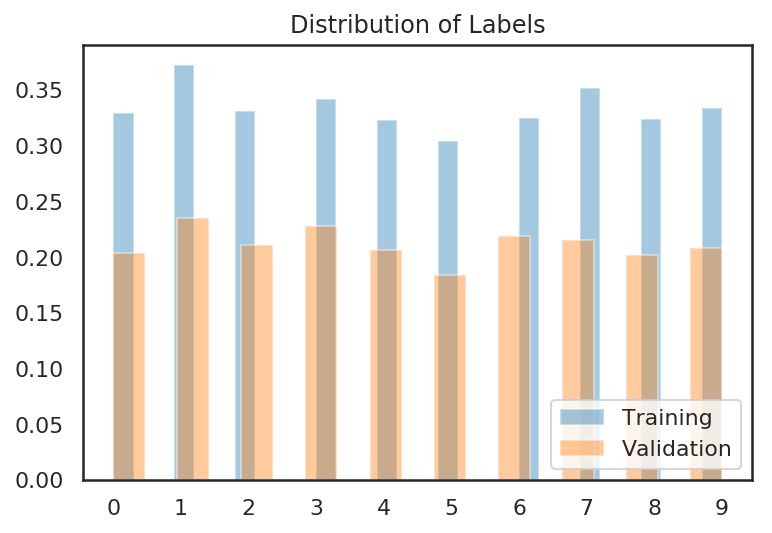

In [6]:
fig, ax = plt.subplots()
ax = sns.distplot(y_train, kde=False, norm_hist=True, label='Training')
ax = sns.distplot(y_valid, kde=False, norm_hist=True, label='Validation')
_ = ax.set_xticks(np.arange(0,10,1))
_ = plt.legend(loc='lower right')
_ = plt.title('Distribution of Labels')

## Visualize Dimensionality [TSNE]

In [7]:
from MulticoreTSNE import MulticoreTSNE as TSNE
import plotly

plotly.offline.init_notebook_mode(connected=True)
import plotly.offline as pltly
from plotly import tools
import plotly.graph_objs as plgo

def TSNE_3d(points, labels, title):
    
    data = []
    marks = lambda x: {'size':8,
                       'line':{'color':plt.cm.Set1(x/10.0)},
                       'opacity':0.75}
    
    x, y = points[:,0], points[:,1]
    
    for _num in range(10):
        idx = np.array(labels == _num).astype(np.bool).reshape(-1)
        scatter = plgo.Scatter(x = x[idx], y = y[idx],
                                 mode = 'markers',
                                 marker = marks(_num),
                                 text = [f'{_num}'],
                                 name = f'{_num}',
                                 hoverinfo='name')
        data.append(scatter)
    layout = plgo.Layout(margin={'l':0, 'r':0, 'b':0, 't':0},
                         title=title)
    fig = plgo.Figure(data=data, layout=layout)
    pltly.iplot(fig, filename=title)


In [8]:
start = time()
plotfor = 5000
plot = TSNE(n_components=2, 
            n_iter=1000,
            n_iter_without_progress=250,
            n_jobs=8,
            random_state=42).fit_transform(X=x_train[:plotfor].reshape(-1,784))

TSNE_3d(plot, y_train[:plotfor].reshape(-1), f'3D tSNE plot{(time()-start):.2f}s')

## Prepare Data for loading

### Augmentor <sup>[1](https://github.com/mdbloice/Augmentor)</sup> Visions Transform and Dataloader Pipeline.

In [9]:
# define augmentor groups

base_aug = Augmentor.Pipeline()
eight_aug = Augmentor.Pipeline()
three_aug = Augmentor.Pipeline()

# for threes
three_aug.flip_top_bottom(probability=0.5)

# for eights
eight_aug.flip_top_bottom(probability=0.5)
eight_aug.flip_left_right(probability=0.5)

for aug in (base_aug, three_aug, eight_aug):
    aug.skew_tilt(probability=0.5, magnitude=0.2)
    aug.rotate(probability=0.5, max_left_rotation=15, max_right_rotation=15)
    aug.shear(probability=0.5, max_shear_left=15, max_shear_right=15)
    aug.zoom(probability=0.5, min_factor=0.95, max_factor=1.05)
    aug.random_distortion(probability=0.5, 
                      grid_width=14, grid_height=14, 
                      magnitude=1)

augsdict = {3:three_aug,8:eight_aug}

for x in np.arange(0,10,1):
    if x not in (3,8):
        augsdict[x]=base_aug
    
len(base_aug.operations), len(three_aug.operations), len(eight_aug.operations)

(5, 6, 7)

image shape: (torch.Size([1, 28, 28]), 'torch.FloatTensor'), target: 3


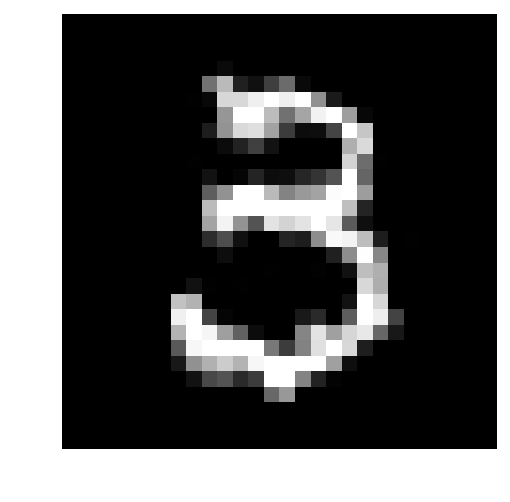

In [10]:
class AugDataset(Dataset):

    def __init__(self, x=x_train, y=y_train, istrain=True):
        super().__init__()

        self.x = x
        self.y = y        
        self.len = len(self.x)
        
        self.istrain = istrain
        
        self.normalize = transforms.Normalize((0.1307,),(0.3081,))
        self.testaug = transforms.Compose([transforms.ToTensor(),
                                           self.normalize])
        self.augmentor = None
            
    def __len__(self):

        return self.len
    
    def expandcast(self, seg):
        # HxWxC, UINT8
        return np.expand_dims(seg, -1).astype(np.uint8)
    
    def torchcast(self, seg):
        return tc.from_numpy(np.array(seg)).type(tc.LongTensor)
    
    def get_transformer(self, aug):
    
        train_transform_list = [transforms.ToPILImage(),
                                aug.torch_transform(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,),(0.3081,))]

        return transforms.Compose(train_transform_list)


    def __getitem__(self, index):

        if self.y is not None:
            image, label = self.x[index], self.y[index]
            self.augmentor = self.get_transformer(augsdict[np.int(label)])
            label = self.torchcast(label)
        else:
            image = self.x[index]
        
        image = self.expandcast(image)
        
        if self.istrain:
            image = self.augmentor(image)
        else:
            image = self.testaug(image)
        
        if self.y is None:
            return image
        else:
            return image, label
        
def squeeze_targets(batch):
    # not needed
    data = tc.stack([item[0] for item in batch])
    target = tc.stack([item[1] for item in batch])
    
    return [data, target.view(-1)]

# test
test_set = AugDataset(istrain=True)
img, labl = test_set.__getitem__(0)
print(f'image shape: {img.shape, img.type()}, target: {labl}')
_ = plt.imshow(img.reshape(28, 28), cmap='gray')
_ = plt.axis('off')

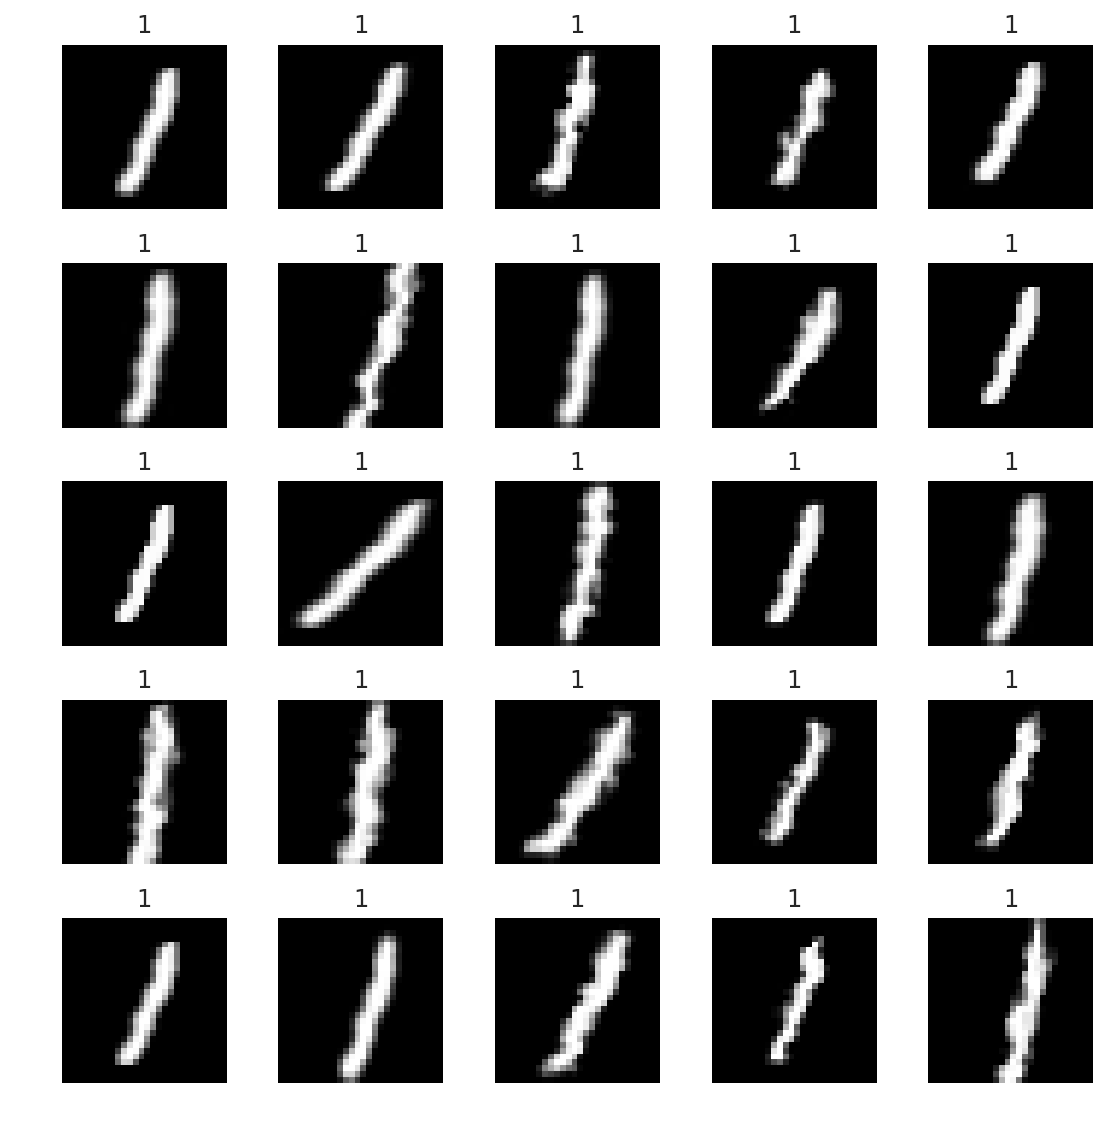

In [11]:
# test
test_set = AugDataset()

fig, axes = plt.subplots(5, 5, figsize=(8,8), sharex=True, sharey=True)
_plots = None

numtrial = np.random.randint(0, x_train.shape[0])
for axs in axes:
    for ax in axs:
        data = test_set.__getitem__(numtrial)
        _ = ax.imshow(data[0].reshape(28, 28), cmap='gray');
        _ = ax.set_title(str(data[1].numpy()))
        _ = ax.set_axis_off()

plt.subplots_adjust(hspace=0.25)
plt.tight_layout()
plt.show()

In [12]:
Trainset = AugDataset(x=x_train, y=y_train, istrain=True)
ValSet = AugDataset(x=x_valid, y=y_valid, istrain=False)
TestSet = AugDataset(x=x_test, y=None, istrain=False)
DummySet = AugDataset(x=x_train, y=None, istrain=False)

NN_trainloader = DataLoader(Trainset,
                            batch_size=420,
                            shuffle=True,
                            num_workers=8,
                            pin_memory=True)

NN_valloader = DataLoader(ValSet,
                           batch_size=420,
                           shuffle=True,
                           num_workers=8,
                           pin_memory=True)


NN_testloader = DataLoader(TestSet,
                           batch_size=1,
                           shuffle=False,
                           num_workers=0,
                           pin_memory=True)
                      
NN_dummyloader = DataLoader(DummySet,
                           batch_size=1,
                           shuffle=False,
                           num_workers=0,
                           pin_memory=True)


# test

img, lbl = next(iter(NN_trainloader))
print(img.shape, lbl.shape)
img, lbl = next(iter(NN_valloader))
print(img.shape, lbl.shape)
img = next(iter(NN_testloader))
print(img.shape)

torch.Size([420, 1, 28, 28]) torch.Size([420])
torch.Size([420, 1, 28, 28]) torch.Size([420])
torch.Size([1, 1, 28, 28])


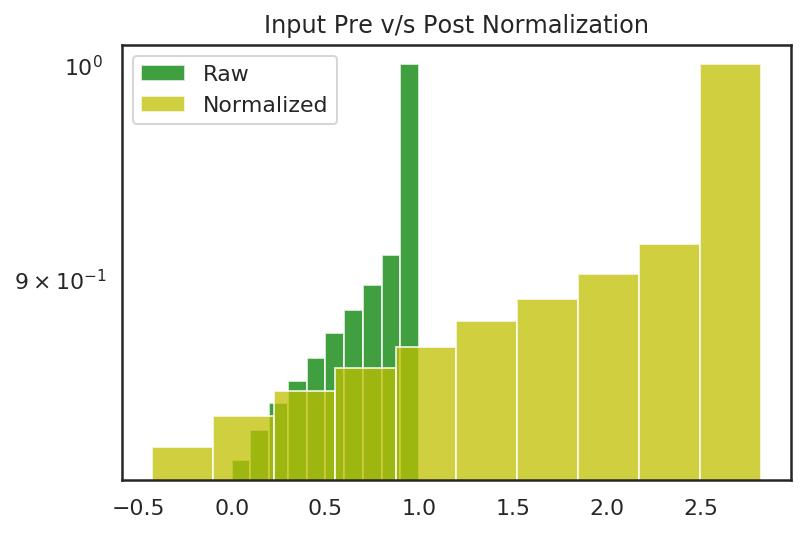

In [13]:
raw = x_valid[:420].astype(np.float32).reshape(-1)/255
norm = next(iter(NN_valloader))[0].numpy().reshape(-1)
bins = 10
_ = plt.hist(raw, bins=bins, density=True,
             cumulative=True, label='Raw', histtype='bar',
             alpha=0.75,log=True, color='g')

_ = plt.hist(norm, bins=bins, density=True,
             cumulative=True, label='Normalized',
             histtype='bar', alpha=0.75,
             log=True, color='y')

_ = plt.legend()
_ = plt.title('Input Pre v/s Post Normalization')

## Define NN Architecture

In [14]:
# resnet-ish

def initialize_weights(module):
    if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight.data, mode='fan_out')
    elif isinstance(module, nn.BatchNorm2d):
        module.weight.data.fill_(1)
        module.bias.data.zero_()
    elif isinstance(module, nn.Linear):
        module.bias.data.zero_()


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,  # downsample with first conv
            padding=1,
            bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut.add_module(
                'conv',
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=stride,  # downsample
                    padding=0,
                    bias=False))
            self.shortcut.add_module('bn', nn.BatchNorm2d(out_channels))  # BN

    def forward(self, x):
        y = fu.relu(self.bn1(self.conv1(x)), inplace=True)
        y = self.bn2(self.conv2(y))
        y += self.shortcut(x)
        y = fu.relu(y, inplace=True)  # apply ReLU after addition
        return y


class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride):
        super(BottleneckBlock, self).__init__()

        bottleneck_channels = out_channels // self.expansion

        self.conv1 = nn.Conv2d(
            in_channels,
            bottleneck_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False)
        self.bn1 = nn.BatchNorm2d(bottleneck_channels)

        self.conv2 = nn.Conv2d(
            bottleneck_channels,
            bottleneck_channels,
            kernel_size=3,
            stride=stride,  # downsample with 3x3 conv
            padding=1,
            bias=False)
        self.bn2 = nn.BatchNorm2d(bottleneck_channels)

        self.conv3 = nn.Conv2d(
            bottleneck_channels,
            out_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()  # identity
        if in_channels != out_channels:
            self.shortcut.add_module(
                'conv',
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=stride,  # downsample
                    padding=0,
                    bias=False))
            self.shortcut.add_module('bn', nn.BatchNorm2d(out_channels))  # BN

    def forward(self, x):
        y = fu.relu(self.bn1(self.conv1(x)), inplace=True)
        y = fu.relu(self.bn2(self.conv2(y)), inplace=True)
        y = self.bn3(self.conv3(y))  # not apply ReLU
        y += self.shortcut(x)
        return y


class MNIST_CNN(nn.Module):
    def __init__(self, config):
        super(MNIST_CNN, self).__init__()

        input_shape = config['input_shape']
        n_classes = config['n_classes']

        base_channels = config['base_channels']
        block_type = config['block_type']
        depth = config['depth']

        assert block_type in ['basic', 'bottleneck']
        if block_type == 'basic':
            block = BasicBlock
            n_blocks_per_stage = (depth - 2) // 6
            assert n_blocks_per_stage * 6 + 2 == depth
        else:
            block = BottleneckBlock
            n_blocks_per_stage = (depth - 2) // 9
            assert n_blocks_per_stage * 9 + 2 == depth

        n_channels = [
            base_channels, base_channels * 2 * block.expansion,
            base_channels * 4 * block.expansion
        ]

        self.conv = nn.Conv2d(
            input_shape[1],
            n_channels[0],
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False)
        self.bn = nn.BatchNorm2d(base_channels)

        self.stage1 = self._make_stage(
            n_channels[0], n_channels[0], n_blocks_per_stage, block, stride=1)
        self.stage2 = self._make_stage(
            n_channels[0], n_channels[1], n_blocks_per_stage, block, stride=2)
        self.stage3 = self._make_stage(
            n_channels[1], n_channels[2], n_blocks_per_stage, block, stride=2)

        # compute conv feature size
        with tc.no_grad():
            self.feature_size = self._forward_conv(
                tc.zeros(*input_shape)).view(-1).shape[0]

        self.fc = nn.Sequential(
            nn.Linear(self.feature_size, self.feature_size*2),
            nn.Dropout(p=0.25, inplace=True),
            nn.ReLU(True),
            nn.Linear(self.feature_size*2, n_classes)
        )

        # initialize weights
        self.apply(initialize_weights)

    def _make_stage(self, in_channels, out_channels, n_blocks, block, stride):
        stage = nn.Sequential()
        for index in range(n_blocks):
            block_name = 'block{}'.format(index + 1)
            if index == 0:
                stage.add_module(
                    block_name, block(
                        in_channels, out_channels, stride=stride))
            else:
                stage.add_module(block_name,
                                 block(out_channels, out_channels, stride=1))
        return stage

    def _forward_conv(self, x):
        x = fu.relu(self.bn(self.conv(x)), inplace=True)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = fu.adaptive_avg_pool2d(x, output_size=1)
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 28, 28]           2,304
       BatchNorm2d-2          [-1, 256, 28, 28]             512
            Linear-3                  [-1, 512]         131,584
           Dropout-4                  [-1, 512]               0
              ReLU-5                  [-1, 512]               0
            Linear-6                   [-1, 10]           5,130
Total params: 139,530
Trainable params: 139,530
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 3.07
Params size (MB): 0.53
Estimated Total Size (MB): 3.61
----------------------------------------------------------------
None


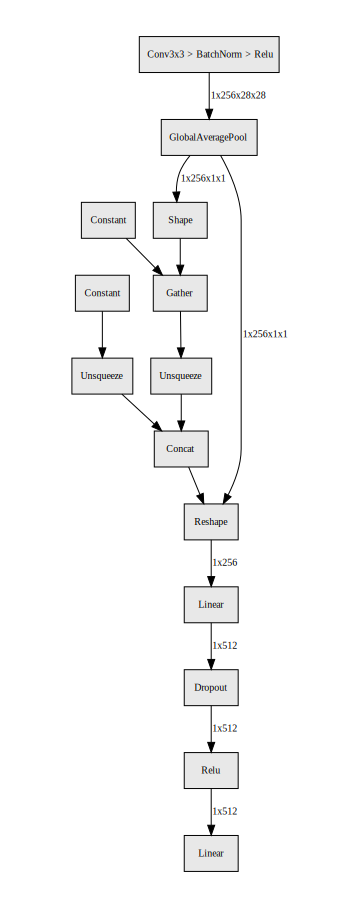

In [15]:
# test

config = {'input_shape':(1,1,28,28),
          'n_classes':10,
          'block_type':'bottleneck',
          'base_channels':256,
          'depth':2}

test_cnn = MNIST_CNN(config).cuda()
print(summary(test_cnn.cuda(), (1,28,28), device='cuda'))
hl.build_graph(model=test_cnn.cuda(), args=tc.randn(1,1,28,28).cuda())

## Prepare for Training

In [16]:
class CNN_trainer():

    def __init__(self, cfg, filename, 
                 trainloader, testloader, lr=0.001,  
                 savedir='./saves', savevery=5,
                 wcuda=True, starting_epoch=0):
        
        self.model = MNIST_CNN(config=cfg)
    
        self.trainloader = trainloader
        self.testloader = testloader
        
        self.lr = lr
        self.lossfn = fu.cross_entropy
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.metrics = {'accuracy':Accuracy(),
                        'loss':Loss(self.lossfn)}
        self.trn_records = {k:[] for k in self.metrics.keys()}
        self.val_records = {k:[] for k in self.metrics.keys()}
        self.bwise_losses = []
        
        if wcuda:
            self.wcuda, self.device = True, 'cuda'
        else:
            self.wcuda, self.device = False, 'cpu'
            
        self.savevery = savevery     
        self.savedir = savedir
        self.filename = filename
        self.run = self.__call__
        if starting_epoch > 0:
            try:
                self.loadstates(False)
            except:
                print(f'model state for {self.filename}_final.pth \
                        could not be loaded!, starting anew.')
                self.epoch = 0
        else:
            self.epoch = 0
        
    def loadstate(self, loadbest=True, set_epoch=False):
            
        if loadbest:
            path = self.savedir+'/'+self.filename+'_best.pth'
        else:
            path = self.savedir+'/'+self.filename+'_final.pth'
        if os.path.isfile(path):
            print(f'file {path} found')
            chkpt = tc.load(path)
            try:
                self.model.load_state_dict(chkpt['model_state']())
                self.optimizer.load_state_dict(chkpt['optimizer_state']())
                if set_epoch:
                    self.epoch = chkpt['epoch']
            except:
                print('model state could not be loaded,\
                        check if model matches weights file')
        else:
            print(f'file at {path} does not exist!')
            raise FileNotFoundError
    
    def __call__(self, max_epochs, log_interval):
        
        gc.collect()
        if self.wcuda:
            tc.backends.cudnn.enabled = True
            tc.cuda.empty_cache()
            
        desc = "ITERATION - loss: {:.6f}"
        pbar = tqdm(initial=0, leave=False, total=len(self.trainloader),
                    desc=desc.format(0))
        
        trainer = create_supervised_trainer(self.model,
                                            self.optimizer,
                                            self.lossfn,
                                            device=self.device,
                                            non_blocking=True)

        evaluator = create_supervised_evaluator(self.model,
                                                self.metrics,
                                                device=self.device,
                                                non_blocking=True)
        
        scheduler = CosineAnnealingScheduler(self.optimizer, 'lr',
                                             self.lr*10, self.lr/10,
                                             len(self.trainloader))
        trainer.add_event_handler(Events.ITERATION_COMPLETED, scheduler)
        
        @trainer.on(Events.STARTED)
        def start_at_epoch(engine):
            if engine.state.epoch != self.epoch:
                pbar.write(f'Starting from epoch:{self.epoch}')
                engine.state.epoch = self.epoch
                
        @trainer.on(Events.ITERATION_COMPLETED)
        def log_training_losses(engine):
            
            iter_ = (engine.state.iteration - 1) % len(self.trainloader) + 1
            
            if iter_ % log_interval == 0:
                pbar.desc = desc.format(engine.state.output)
                pbar.update(log_interval)
            
            records = engine.state.output
            self.bwise_losses.append(records)
            
        @trainer.on(Events.EPOCH_COMPLETED)
        def log_training_results(engine):
            self.epoch = engine.state.epoch
            pbar.refresh()
            self.model.eval()
            evaluator.run(self.trainloader)
            metrics = evaluator.state.metrics
            avg_accuracy = metrics['accuracy']
            avg_nll = metrics['loss']

            tqdm_str = "Training Results - Epoch: {}  \
                        Avg accuracy: {:.6f} Avg loss: {:.6f}"
            pbar.write(tqdm_str.format(engine.state.epoch,
                                        avg_accuracy, avg_nll))

            for k in self.metrics.keys():
                self.trn_records[k].append(metrics[k])
            self.model.train()

        @trainer.on(Events.EPOCH_COMPLETED)
        def log_validation_results(engine):
            self.model.eval()
            evaluator.run(self.testloader)
            metrics = evaluator.state.metrics
            avg_accuracy = metrics['accuracy']
            avg_nll = metrics['loss']

            tqdm_str = "Validation Results - Epoch: {}  \
                        Avg accuracy: {:.6f} Avg loss: {:.6f}"
            pbar.write(tqdm_str.format(engine.state.epoch,
                                        avg_accuracy, avg_nll))
            pbar.n = pbar.last_print_n = 0

            for k in self.metrics.keys():
                self.val_records[k].append(metrics[k])
            self.model.train()
                
        @trainer.on(Events.EPOCH_COMPLETED)
        def save_model(engine):
            checkin = self.val_records['accuracy']
            filename = f'{self.filename}_best.pth'
            tqdm_str = f'Saving Model... to {self.savedir} \
                        as {filename}'
            if engine.state.epoch % self.savevery == 0:
                if checkin[-1] > np.mean(checkin):
                    pbar.write(tqdm_str)
                    self.model.eval()
                    savedict = {'model_object':self.model,
                                'model_state':self.model.state_dict,
                                'optimizer_state':self.optimizer.state_dict,
                                'epoch':engine.state.epoch,
                                'accuracy':self.trn_records['accuracy'],
                                'loss':self.trn_records['loss']}
                    tc.save(savedict, self.savedir+'/'+filename)
                else:
                    pbar.write('Non-Optimal Model State, Skipping Saving..')
            self.model.train()
                    
        @trainer.on(Events.COMPLETED)
        def save_final_model(engine):
            filename = f'{self.filename}_final.pth'
            tqdm_str = f'Saving Final Model... to {self.savedir} \
                        as {filename}'
            pbar.write(tqdm_str)
            self.model.eval()
            savedict = {'model_object':self.model,
                        'model_state':self.model.state_dict,
                        'optimizer_state':self.optimizer.state_dict,
                        'epoch':engine.state.epoch,
                        'accuracy':self.trn_records['accuracy'],
                        'loss':self.trn_records['loss']}
            tc.save(savedict, self.savedir+'/'+filename)
            self.model.train()
            
        self.max_epochs = max_epochs
        trainer.run(self.trainloader, max_epochs)
        pbar.close()
        
    def plot(self, prefix=None):
        
        fig = plt.figure(figsize=(12,6))
        ax = plt.subplot(111)
        ax2 = ax.twinx().twiny()
        plt.rc('grid', linestyle="--", color='gray')
        plt.minorticks_on()
        
        #override title
        if prefix is None:
            prefix=self.filename
        
        plots = [self.trn_records['accuracy'],
                 self.trn_records['loss'],
                 self.val_records['accuracy'],
                 self.val_records['loss']]
        
        labels = ['Training Accuracy',
                  'Training Loss',
                  'Validation Accuracy',
                  'Validation Loss']
        
        colors = ['xkcd:lime', 'xkcd:green', 'xkcd:red', 'xkcd:cerise']
        linestyles = ['-', '--', '-', '--']
        markers = ['o', '+', 'x', '*']


        for series, lab, col, ls, mrk in zip(plots, labels, colors, linestyles, markers):
            ax.plot(series, marker=mrk, linewidth=1, label=lab, color=col, linestyle=ls)
            ax.set_xlabel('Epochs')

        ax2.plot(self.bwise_losses, label='Batchwise Losses', alpha=0.5,
                    color='blue', linestyle='--', linewidth=1)
        ax2.set_xlabel('Batches', color='blue')
        ax2.xaxis.set_ticks_position('bottom')
        ax2.xaxis.set_label_position('bottom')
        ax2.spines['bottom'].set_position(('axes', -0.20))
        ax2.spines['bottom'].set_color('blue')
        ax2.spines['right'].set_color('blue')
        ax2.yaxis.tick_right()
        ax2.yaxis.set_label_position("right")
        ax2.tick_params(axis='y', colors='blue')

        ax.legend(loc='center left', frameon=True, bbox_to_anchor=(1.05, 0.5),
                      ncol=1, fancybox=True)
        ax2.legend(loc='center left', frameon=True, bbox_to_anchor=(1.05, 0.75),
                      ncol=1, fancybox=True)
        ax.grid(which='major', color='black', linestyle='--')
        ax.grid(which='minor', color='gray', linestyle=':')
        plt.title(label=f'Model: {prefix}', loc='center')
  
        plt.show()

## Train and Visualize Results

In [17]:
config1 = {'input_shape':(1,1,28,28),
          'n_classes':10,
          'block_type':'bottleneck',
          'base_channels':64,
          'depth':11}

config2 = {'input_shape':(1,1,28,28),
          'n_classes':10,
          'block_type':'bottleneck',
          'base_channels':48,
          'depth':29}

config3 = {'input_shape':(1,1,28,28),
          'n_classes':10,
          'block_type':'basic',
          'base_channels':64,
          'depth':8}

config4 = {'input_shape':(1,1,28,28),
          'n_classes':10,
          'block_type':'basic',
          'base_channels':64,
          'depth':14}

config5 = {'input_shape':(1,1,28,28),
          'n_classes':10,
          'block_type':'basic',
          'base_channels':64,
          'depth':20}


models_dict = {1:(config1, 'MNIST_RESN_BNECK_64x11'),
               2:(config2, 'MNIST_RESN_BNECK_48x29'),
               3:(config3, 'MNIST_RESN_BASIC_64x8'),
               4:(config4, 'MNIST_RESN_BASIC_64x14'),
               5:(config5, 'MNIST_RESN_BASIC_64x20')}


trainer_dict = {x:CNN_trainer(*models_dict[x], NN_trainloader, NN_valloader) \
                for x in models_dict.keys()}

Training Results - Epoch: 1                          Avg accuracy: 0.910744 Avg loss: 0.295842
Validation Results - Epoch: 1                          Avg accuracy: 0.936667 Avg loss: 0.225013
Training Results - Epoch: 2                          Avg accuracy: 0.946012 Avg loss: 0.167887
Validation Results - Epoch: 2                          Avg accuracy: 0.963095 Avg loss: 0.114614
Training Results - Epoch: 3                          Avg accuracy: 0.962768 Avg loss: 0.122390
Validation Results - Epoch: 3                          Avg accuracy: 0.969048 Avg loss: 0.089621
Training Results - Epoch: 4                          Avg accuracy: 0.969345 Avg loss: 0.099535
Validation Results - Epoch: 4                          Avg accuracy: 0.976786 Avg loss: 0.071757
Training Results - Epoch: 5                          Avg accuracy: 0.971101 Avg loss: 0.092401
Validation Results - Epoch: 5                          Avg accuracy: 0.979405 Avg loss: 0.062342
Saving Model... to ./saves              

/home/alk/.anaconda/envs/dsci/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning:

Couldn't retrieve source code for container of type MNIST_CNN. It won't be checked for correctness upon loading.

/home/alk/.anaconda/envs/dsci/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning:

Couldn't retrieve source code for container of type BottleneckBlock. It won't be checked for correctness upon loading.



Training Results - Epoch: 6                          Avg accuracy: 0.973899 Avg loss: 0.082717
Validation Results - Epoch: 6                          Avg accuracy: 0.980000 Avg loss: 0.058618
Training Results - Epoch: 7                          Avg accuracy: 0.976637 Avg loss: 0.074184
Validation Results - Epoch: 7                          Avg accuracy: 0.982738 Avg loss: 0.049825
Training Results - Epoch: 8                          Avg accuracy: 0.977946 Avg loss: 0.070708
Validation Results - Epoch: 8                          Avg accuracy: 0.983452 Avg loss: 0.050905
Training Results - Epoch: 9                          Avg accuracy: 0.979286 Avg loss: 0.066738
Validation Results - Epoch: 9                          Avg accuracy: 0.984048 Avg loss: 0.046436
Training Results - Epoch: 10                          Avg accuracy: 0.981935 Avg loss: 0.059275
Validation Results - Epoch: 10                          Avg accuracy: 0.986310 Avg loss: 0.039974
Saving Model... to ./saves            

Validation Results - Epoch: 45                          Avg accuracy: 0.992381 Avg loss: 0.024002
Saving Model... to ./saves                         as MNIST_RESN_BNECK_64x11_best.pth
Training Results - Epoch: 46                          Avg accuracy: 0.991042 Avg loss: 0.029067
Validation Results - Epoch: 46                          Avg accuracy: 0.991667 Avg loss: 0.024895
Training Results - Epoch: 47                          Avg accuracy: 0.990565 Avg loss: 0.030253
Validation Results - Epoch: 47                          Avg accuracy: 0.991786 Avg loss: 0.025395
Training Results - Epoch: 48                          Avg accuracy: 0.990238 Avg loss: 0.029280
Validation Results - Epoch: 48                          Avg accuracy: 0.992024 Avg loss: 0.023553
Training Results - Epoch: 49                          Avg accuracy: 0.990893 Avg loss: 0.027270
Validation Results - Epoch: 49                          Avg accuracy: 0.992024 Avg loss: 0.024792
Training Results - Epoch: 50            

Validation Results - Epoch: 84                          Avg accuracy: 0.993214 Avg loss: 0.021239
Training Results - Epoch: 85                          Avg accuracy: 0.992976 Avg loss: 0.022890
Validation Results - Epoch: 85                          Avg accuracy: 0.992738 Avg loss: 0.022300
Saving Model... to ./saves                         as MNIST_RESN_BNECK_64x11_best.pth
Training Results - Epoch: 86                          Avg accuracy: 0.993006 Avg loss: 0.021795
Validation Results - Epoch: 86                          Avg accuracy: 0.992738 Avg loss: 0.023018
Training Results - Epoch: 87                          Avg accuracy: 0.993452 Avg loss: 0.021012
Validation Results - Epoch: 87                          Avg accuracy: 0.993333 Avg loss: 0.020022
Training Results - Epoch: 88                          Avg accuracy: 0.993571 Avg loss: 0.021003
Validation Results - Epoch: 88                          Avg accuracy: 0.993690 Avg loss: 0.020884
Training Results - Epoch: 89            

Training Results - Epoch: 123                          Avg accuracy: 0.995179 Avg loss: 0.015285
Validation Results - Epoch: 123                          Avg accuracy: 0.994405 Avg loss: 0.018286
Training Results - Epoch: 124                          Avg accuracy: 0.994107 Avg loss: 0.018692
Validation Results - Epoch: 124                          Avg accuracy: 0.993571 Avg loss: 0.020024
Training Results - Epoch: 125                          Avg accuracy: 0.993869 Avg loss: 0.019022
Validation Results - Epoch: 125                          Avg accuracy: 0.994167 Avg loss: 0.019164
Saving Model... to ./saves                         as MNIST_RESN_BNECK_64x11_best.pth
Training Results - Epoch: 126                          Avg accuracy: 0.994196 Avg loss: 0.018554
Validation Results - Epoch: 126                          Avg accuracy: 0.994167 Avg loss: 0.018542
Training Results - Epoch: 127                          Avg accuracy: 0.994167 Avg loss: 0.018832
Validation Results - Epoch: 127  

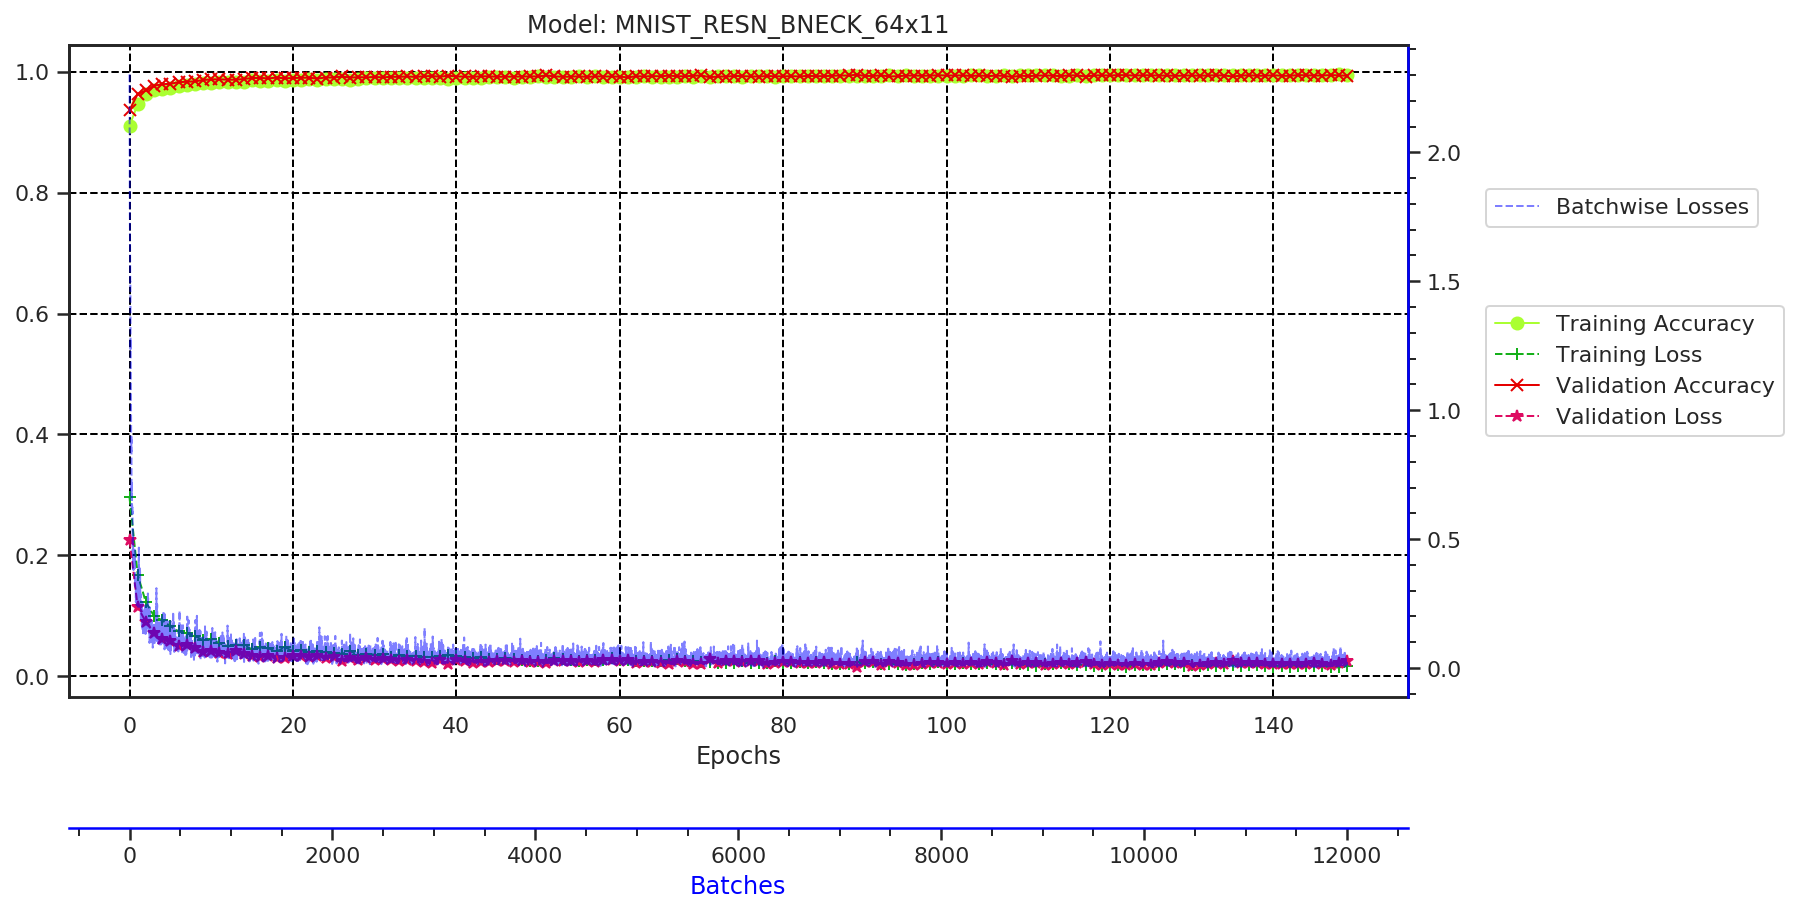

In [18]:
# 1, set epoch to 0 to retrain trained models, if re-running cell.
# trainer_dict[1].epoch = 0

trainer_dict[1].lr = 0.0001
trainer_dict[1](150, log_interval=1)
trainer_dict[1].plot()

Training Results - Epoch: 1                          Avg accuracy: 0.961726 Avg loss: 0.125066
Validation Results - Epoch: 1                          Avg accuracy: 0.972024 Avg loss: 0.089262
Training Results - Epoch: 2                          Avg accuracy: 0.979018 Avg loss: 0.067314
Validation Results - Epoch: 2                          Avg accuracy: 0.984048 Avg loss: 0.048115
Training Results - Epoch: 3                          Avg accuracy: 0.982054 Avg loss: 0.057094
Validation Results - Epoch: 3                          Avg accuracy: 0.986905 Avg loss: 0.038418
Training Results - Epoch: 4                          Avg accuracy: 0.984435 Avg loss: 0.049706
Validation Results - Epoch: 4                          Avg accuracy: 0.989286 Avg loss: 0.032601
Training Results - Epoch: 5                          Avg accuracy: 0.987083 Avg loss: 0.043355
Validation Results - Epoch: 5                          Avg accuracy: 0.990714 Avg loss: 0.029427
Saving Model... to ./saves              

Validation Results - Epoch: 40                          Avg accuracy: 0.994167 Avg loss: 0.019550
Saving Model... to ./saves                         as MNIST_RESN_BNECK_48x29_best.pth
Training Results - Epoch: 41                          Avg accuracy: 0.994048 Avg loss: 0.019343
Validation Results - Epoch: 41                          Avg accuracy: 0.994167 Avg loss: 0.018409
Training Results - Epoch: 42                          Avg accuracy: 0.993750 Avg loss: 0.020790
Validation Results - Epoch: 42                          Avg accuracy: 0.994286 Avg loss: 0.018466
Training Results - Epoch: 43                          Avg accuracy: 0.994077 Avg loss: 0.018513
Validation Results - Epoch: 43                          Avg accuracy: 0.994524 Avg loss: 0.017559
Training Results - Epoch: 44                          Avg accuracy: 0.994167 Avg loss: 0.018086
Validation Results - Epoch: 44                          Avg accuracy: 0.994881 Avg loss: 0.017543
Training Results - Epoch: 45            

Validation Results - Epoch: 79                          Avg accuracy: 0.995357 Avg loss: 0.016838
Training Results - Epoch: 80                          Avg accuracy: 0.994911 Avg loss: 0.015212
Validation Results - Epoch: 80                          Avg accuracy: 0.995595 Avg loss: 0.019000
Saving Model... to ./saves                         as MNIST_RESN_BNECK_48x29_best.pth
Training Results - Epoch: 81                          Avg accuracy: 0.995446 Avg loss: 0.014544
Validation Results - Epoch: 81                          Avg accuracy: 0.996190 Avg loss: 0.014866
Training Results - Epoch: 82                          Avg accuracy: 0.994554 Avg loss: 0.017252
Validation Results - Epoch: 82                          Avg accuracy: 0.995714 Avg loss: 0.018396
Training Results - Epoch: 83                          Avg accuracy: 0.995595 Avg loss: 0.013839
Validation Results - Epoch: 83                          Avg accuracy: 0.995714 Avg loss: 0.017603
Training Results - Epoch: 84            

Validation Results - Epoch: 118                          Avg accuracy: 0.995119 Avg loss: 0.019672
Training Results - Epoch: 119                          Avg accuracy: 0.996339 Avg loss: 0.011746
Validation Results - Epoch: 119                          Avg accuracy: 0.995119 Avg loss: 0.020309
Training Results - Epoch: 120                          Avg accuracy: 0.996071 Avg loss: 0.012858
Validation Results - Epoch: 120                          Avg accuracy: 0.995476 Avg loss: 0.018085
Saving Model... to ./saves                         as MNIST_RESN_BNECK_48x29_best.pth
Training Results - Epoch: 121                          Avg accuracy: 0.996071 Avg loss: 0.012970
Validation Results - Epoch: 121                          Avg accuracy: 0.995119 Avg loss: 0.016988
Training Results - Epoch: 122                          Avg accuracy: 0.995625 Avg loss: 0.014228
Validation Results - Epoch: 122                          Avg accuracy: 0.994643 Avg loss: 0.017512
Training Results - Epoch: 123  

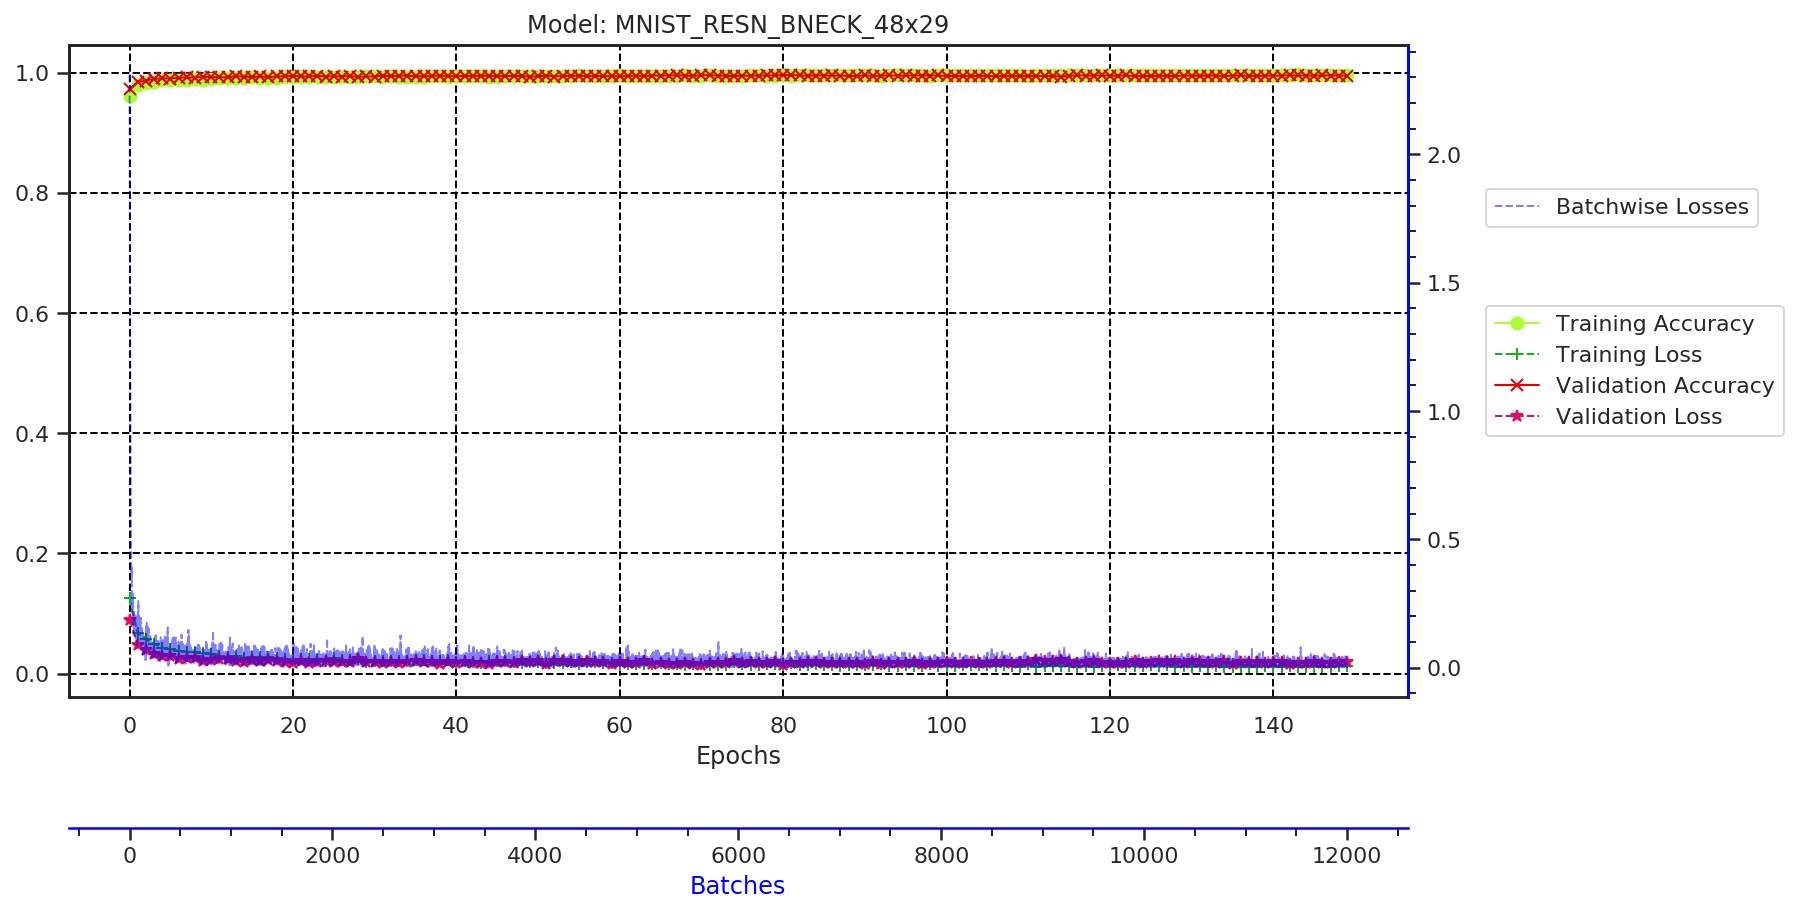

In [19]:
# 2
trainer_dict[2].lr = 0.0001
trainer_dict[2](150, log_interval=1)
trainer_dict[2].plot()

Training Results - Epoch: 1                          Avg accuracy: 0.934792 Avg loss: 0.253750
Validation Results - Epoch: 1                          Avg accuracy: 0.951071 Avg loss: 0.201214
Training Results - Epoch: 2                          Avg accuracy: 0.967024 Avg loss: 0.116994
Validation Results - Epoch: 2                          Avg accuracy: 0.973690 Avg loss: 0.085598
Training Results - Epoch: 3                          Avg accuracy: 0.975060 Avg loss: 0.084834
Validation Results - Epoch: 3                          Avg accuracy: 0.978929 Avg loss: 0.063504
Training Results - Epoch: 4                          Avg accuracy: 0.979315 Avg loss: 0.070417
Validation Results - Epoch: 4                          Avg accuracy: 0.984762 Avg loss: 0.046616
Training Results - Epoch: 5                          Avg accuracy: 0.982679 Avg loss: 0.059031
Validation Results - Epoch: 5                          Avg accuracy: 0.987500 Avg loss: 0.040225
Saving Model... to ./saves              

/home/alk/.anaconda/envs/dsci/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning:

Couldn't retrieve source code for container of type BasicBlock. It won't be checked for correctness upon loading.



Training Results - Epoch: 6                          Avg accuracy: 0.983839 Avg loss: 0.052120
Validation Results - Epoch: 6                          Avg accuracy: 0.988929 Avg loss: 0.034747
Training Results - Epoch: 7                          Avg accuracy: 0.984256 Avg loss: 0.051719
Validation Results - Epoch: 7                          Avg accuracy: 0.987857 Avg loss: 0.035811
Training Results - Epoch: 8                          Avg accuracy: 0.986548 Avg loss: 0.044543
Validation Results - Epoch: 8                          Avg accuracy: 0.990000 Avg loss: 0.030178
Training Results - Epoch: 9                          Avg accuracy: 0.986190 Avg loss: 0.044227
Validation Results - Epoch: 9                          Avg accuracy: 0.989881 Avg loss: 0.030771
Training Results - Epoch: 10                          Avg accuracy: 0.987500 Avg loss: 0.040266
Validation Results - Epoch: 10                          Avg accuracy: 0.990714 Avg loss: 0.027672
Saving Model... to ./saves            

Validation Results - Epoch: 45                          Avg accuracy: 0.994405 Avg loss: 0.018763
Saving Model... to ./saves                         as MNIST_RESN_BASIC_64x8_best.pth
Training Results - Epoch: 46                          Avg accuracy: 0.993214 Avg loss: 0.021405
Validation Results - Epoch: 46                          Avg accuracy: 0.993929 Avg loss: 0.017782
Training Results - Epoch: 47                          Avg accuracy: 0.992708 Avg loss: 0.021716
Validation Results - Epoch: 47                          Avg accuracy: 0.994167 Avg loss: 0.017973
Training Results - Epoch: 48                          Avg accuracy: 0.993363 Avg loss: 0.020891
Validation Results - Epoch: 48                          Avg accuracy: 0.995000 Avg loss: 0.016448
Training Results - Epoch: 49                          Avg accuracy: 0.993125 Avg loss: 0.022201
Validation Results - Epoch: 49                          Avg accuracy: 0.995119 Avg loss: 0.017094
Training Results - Epoch: 50             

Validation Results - Epoch: 84                          Avg accuracy: 0.994167 Avg loss: 0.016760
Training Results - Epoch: 85                          Avg accuracy: 0.995595 Avg loss: 0.014778
Validation Results - Epoch: 85                          Avg accuracy: 0.994405 Avg loss: 0.017399
Saving Model... to ./saves                         as MNIST_RESN_BASIC_64x8_best.pth
Training Results - Epoch: 86                          Avg accuracy: 0.995030 Avg loss: 0.016272
Validation Results - Epoch: 86                          Avg accuracy: 0.994048 Avg loss: 0.017769
Training Results - Epoch: 87                          Avg accuracy: 0.995327 Avg loss: 0.015037
Validation Results - Epoch: 87                          Avg accuracy: 0.994524 Avg loss: 0.015594
Training Results - Epoch: 88                          Avg accuracy: 0.995357 Avg loss: 0.015119
Validation Results - Epoch: 88                          Avg accuracy: 0.995595 Avg loss: 0.014662
Training Results - Epoch: 89             

Training Results - Epoch: 123                          Avg accuracy: 0.995833 Avg loss: 0.013129
Validation Results - Epoch: 123                          Avg accuracy: 0.995595 Avg loss: 0.013934
Training Results - Epoch: 124                          Avg accuracy: 0.995625 Avg loss: 0.013709
Validation Results - Epoch: 124                          Avg accuracy: 0.994524 Avg loss: 0.017626
Training Results - Epoch: 125                          Avg accuracy: 0.995952 Avg loss: 0.012657
Validation Results - Epoch: 125                          Avg accuracy: 0.994881 Avg loss: 0.015444
Saving Model... to ./saves                         as MNIST_RESN_BASIC_64x8_best.pth
Training Results - Epoch: 126                          Avg accuracy: 0.995774 Avg loss: 0.013125
Validation Results - Epoch: 126                          Avg accuracy: 0.993929 Avg loss: 0.017805
Training Results - Epoch: 127                          Avg accuracy: 0.995536 Avg loss: 0.013186
Validation Results - Epoch: 127   

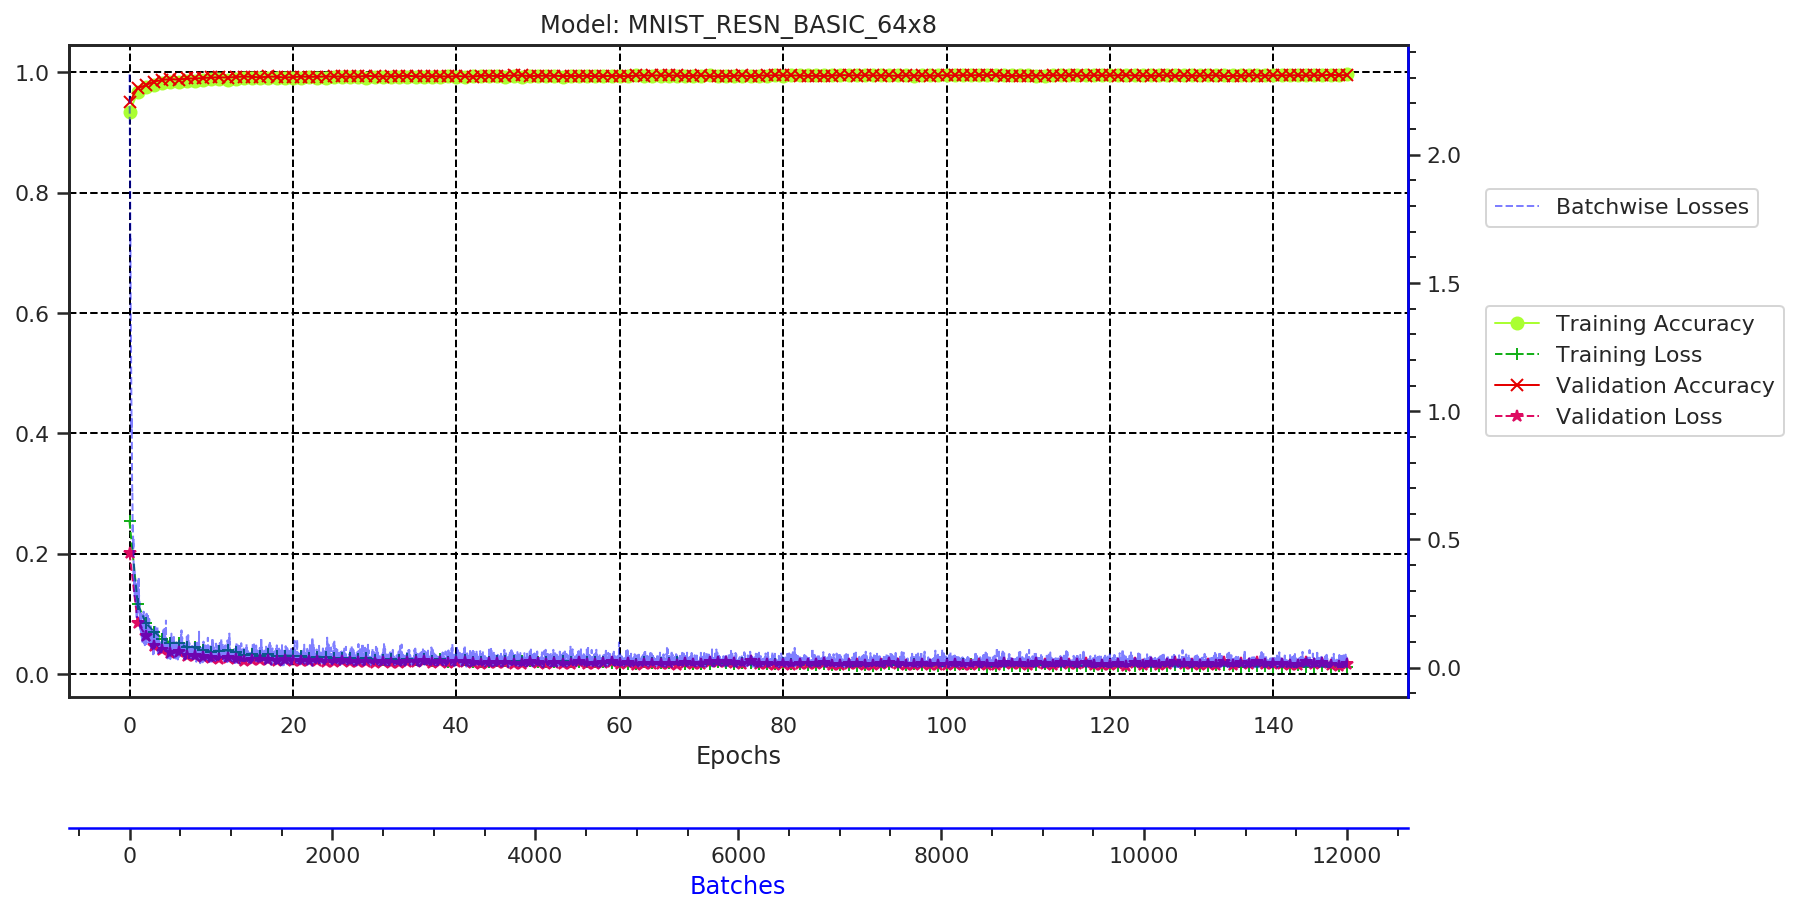

In [20]:
# 3
trainer_dict[3].lr = 0.0001
trainer_dict[3](150, log_interval=1)
trainer_dict[3].plot()

Training Results - Epoch: 1                          Avg accuracy: 0.967976 Avg loss: 0.109353
Validation Results - Epoch: 1                          Avg accuracy: 0.979167 Avg loss: 0.071370
Training Results - Epoch: 2                          Avg accuracy: 0.979345 Avg loss: 0.068829
Validation Results - Epoch: 2                          Avg accuracy: 0.987143 Avg loss: 0.044370
Training Results - Epoch: 3                          Avg accuracy: 0.983244 Avg loss: 0.053664
Validation Results - Epoch: 3                          Avg accuracy: 0.989762 Avg loss: 0.032871
Training Results - Epoch: 4                          Avg accuracy: 0.986071 Avg loss: 0.044717
Validation Results - Epoch: 4                          Avg accuracy: 0.990714 Avg loss: 0.029536
Training Results - Epoch: 5                          Avg accuracy: 0.987500 Avg loss: 0.039629
Validation Results - Epoch: 5                          Avg accuracy: 0.991071 Avg loss: 0.027300
Saving Model... to ./saves              

Validation Results - Epoch: 40                          Avg accuracy: 0.994881 Avg loss: 0.015275
Saving Model... to ./saves                         as MNIST_RESN_BASIC_64x14_best.pth
Training Results - Epoch: 41                          Avg accuracy: 0.993690 Avg loss: 0.019118
Validation Results - Epoch: 41                          Avg accuracy: 0.995000 Avg loss: 0.015394
Training Results - Epoch: 42                          Avg accuracy: 0.994107 Avg loss: 0.018874
Validation Results - Epoch: 42                          Avg accuracy: 0.994405 Avg loss: 0.017435
Training Results - Epoch: 43                          Avg accuracy: 0.994345 Avg loss: 0.018080
Validation Results - Epoch: 43                          Avg accuracy: 0.995476 Avg loss: 0.015056
Training Results - Epoch: 44                          Avg accuracy: 0.994524 Avg loss: 0.016983
Validation Results - Epoch: 44                          Avg accuracy: 0.994643 Avg loss: 0.018144
Training Results - Epoch: 45            

Validation Results - Epoch: 79                          Avg accuracy: 0.995357 Avg loss: 0.014409
Training Results - Epoch: 80                          Avg accuracy: 0.995357 Avg loss: 0.013807
Validation Results - Epoch: 80                          Avg accuracy: 0.995595 Avg loss: 0.014673
Saving Model... to ./saves                         as MNIST_RESN_BASIC_64x14_best.pth
Training Results - Epoch: 81                          Avg accuracy: 0.996458 Avg loss: 0.012109
Validation Results - Epoch: 81                          Avg accuracy: 0.995238 Avg loss: 0.015279
Training Results - Epoch: 82                          Avg accuracy: 0.996607 Avg loss: 0.012385
Validation Results - Epoch: 82                          Avg accuracy: 0.995000 Avg loss: 0.014028
Training Results - Epoch: 83                          Avg accuracy: 0.995833 Avg loss: 0.014272
Validation Results - Epoch: 83                          Avg accuracy: 0.994762 Avg loss: 0.015929
Training Results - Epoch: 84            

Training Results - Epoch: 118                          Avg accuracy: 0.996637 Avg loss: 0.010846
Validation Results - Epoch: 118                          Avg accuracy: 0.995595 Avg loss: 0.015051
Training Results - Epoch: 119                          Avg accuracy: 0.996815 Avg loss: 0.009463
Validation Results - Epoch: 119                          Avg accuracy: 0.995238 Avg loss: 0.017329
Training Results - Epoch: 120                          Avg accuracy: 0.996458 Avg loss: 0.011358
Validation Results - Epoch: 120                          Avg accuracy: 0.993929 Avg loss: 0.019963
Non-Optimal Model State, Skipping Saving..
Training Results - Epoch: 121                          Avg accuracy: 0.996310 Avg loss: 0.011555
Validation Results - Epoch: 121                          Avg accuracy: 0.995476 Avg loss: 0.016229
Training Results - Epoch: 122                          Avg accuracy: 0.996042 Avg loss: 0.011484
Validation Results - Epoch: 122                          Avg accuracy: 0.995

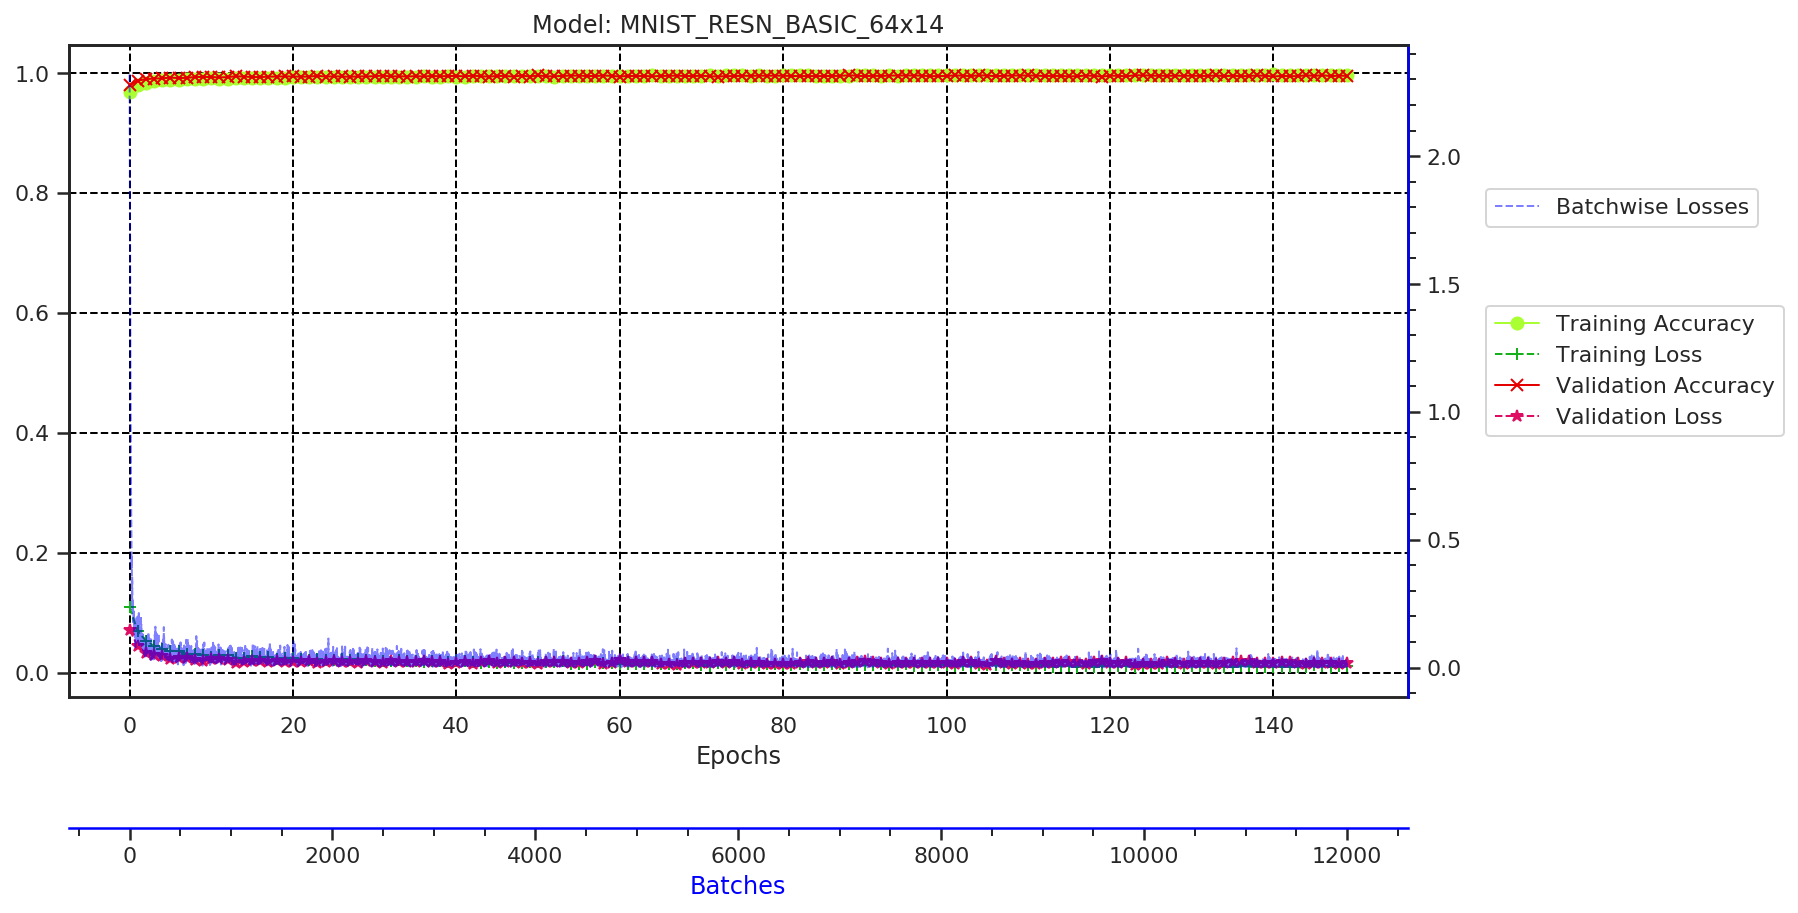

In [21]:
# 4
trainer_dict[4].lr = 0.0001
trainer_dict[4](150, log_interval=1)
trainer_dict[4].plot()

Training Results - Epoch: 1                          Avg accuracy: 0.972113 Avg loss: 0.095282
Validation Results - Epoch: 1                          Avg accuracy: 0.978929 Avg loss: 0.067642
Training Results - Epoch: 2                          Avg accuracy: 0.980208 Avg loss: 0.063594
Validation Results - Epoch: 2                          Avg accuracy: 0.984048 Avg loss: 0.047351
Training Results - Epoch: 3                          Avg accuracy: 0.984137 Avg loss: 0.053603
Validation Results - Epoch: 3                          Avg accuracy: 0.989643 Avg loss: 0.030655
Training Results - Epoch: 4                          Avg accuracy: 0.986012 Avg loss: 0.047392
Validation Results - Epoch: 4                          Avg accuracy: 0.990357 Avg loss: 0.030108
Training Results - Epoch: 5                          Avg accuracy: 0.987232 Avg loss: 0.039876
Validation Results - Epoch: 5                          Avg accuracy: 0.992381 Avg loss: 0.024139
Saving Model... to ./saves              

Validation Results - Epoch: 40                          Avg accuracy: 0.995119 Avg loss: 0.017268
Saving Model... to ./saves                         as MNIST_RESN_BASIC_64x20_best.pth
Training Results - Epoch: 41                          Avg accuracy: 0.993929 Avg loss: 0.018454
Validation Results - Epoch: 41                          Avg accuracy: 0.995119 Avg loss: 0.018950
Training Results - Epoch: 42                          Avg accuracy: 0.994702 Avg loss: 0.017275
Validation Results - Epoch: 42                          Avg accuracy: 0.995000 Avg loss: 0.018207
Training Results - Epoch: 43                          Avg accuracy: 0.994315 Avg loss: 0.018014
Validation Results - Epoch: 43                          Avg accuracy: 0.994286 Avg loss: 0.018269
Training Results - Epoch: 44                          Avg accuracy: 0.994524 Avg loss: 0.018099
Validation Results - Epoch: 44                          Avg accuracy: 0.995000 Avg loss: 0.017200
Training Results - Epoch: 45            

Validation Results - Epoch: 79                          Avg accuracy: 0.995595 Avg loss: 0.015948
Training Results - Epoch: 80                          Avg accuracy: 0.995833 Avg loss: 0.013041
Validation Results - Epoch: 80                          Avg accuracy: 0.995119 Avg loss: 0.016165
Saving Model... to ./saves                         as MNIST_RESN_BASIC_64x20_best.pth
Training Results - Epoch: 81                          Avg accuracy: 0.995714 Avg loss: 0.013660
Validation Results - Epoch: 81                          Avg accuracy: 0.995595 Avg loss: 0.015240
Training Results - Epoch: 82                          Avg accuracy: 0.996042 Avg loss: 0.012224
Validation Results - Epoch: 82                          Avg accuracy: 0.995238 Avg loss: 0.016070
Training Results - Epoch: 83                          Avg accuracy: 0.995982 Avg loss: 0.012236
Validation Results - Epoch: 83                          Avg accuracy: 0.995714 Avg loss: 0.016015
Training Results - Epoch: 84            

Validation Results - Epoch: 118                          Avg accuracy: 0.994643 Avg loss: 0.017695
Training Results - Epoch: 119                          Avg accuracy: 0.996339 Avg loss: 0.011587
Validation Results - Epoch: 119                          Avg accuracy: 0.994405 Avg loss: 0.018978
Training Results - Epoch: 120                          Avg accuracy: 0.996131 Avg loss: 0.012072
Validation Results - Epoch: 120                          Avg accuracy: 0.995476 Avg loss: 0.016469
Saving Model... to ./saves                         as MNIST_RESN_BASIC_64x20_best.pth
Training Results - Epoch: 121                          Avg accuracy: 0.996161 Avg loss: 0.012398
Validation Results - Epoch: 121                          Avg accuracy: 0.995357 Avg loss: 0.017404
Training Results - Epoch: 122                          Avg accuracy: 0.996458 Avg loss: 0.010876
Validation Results - Epoch: 122                          Avg accuracy: 0.995238 Avg loss: 0.017693
Training Results - Epoch: 123  

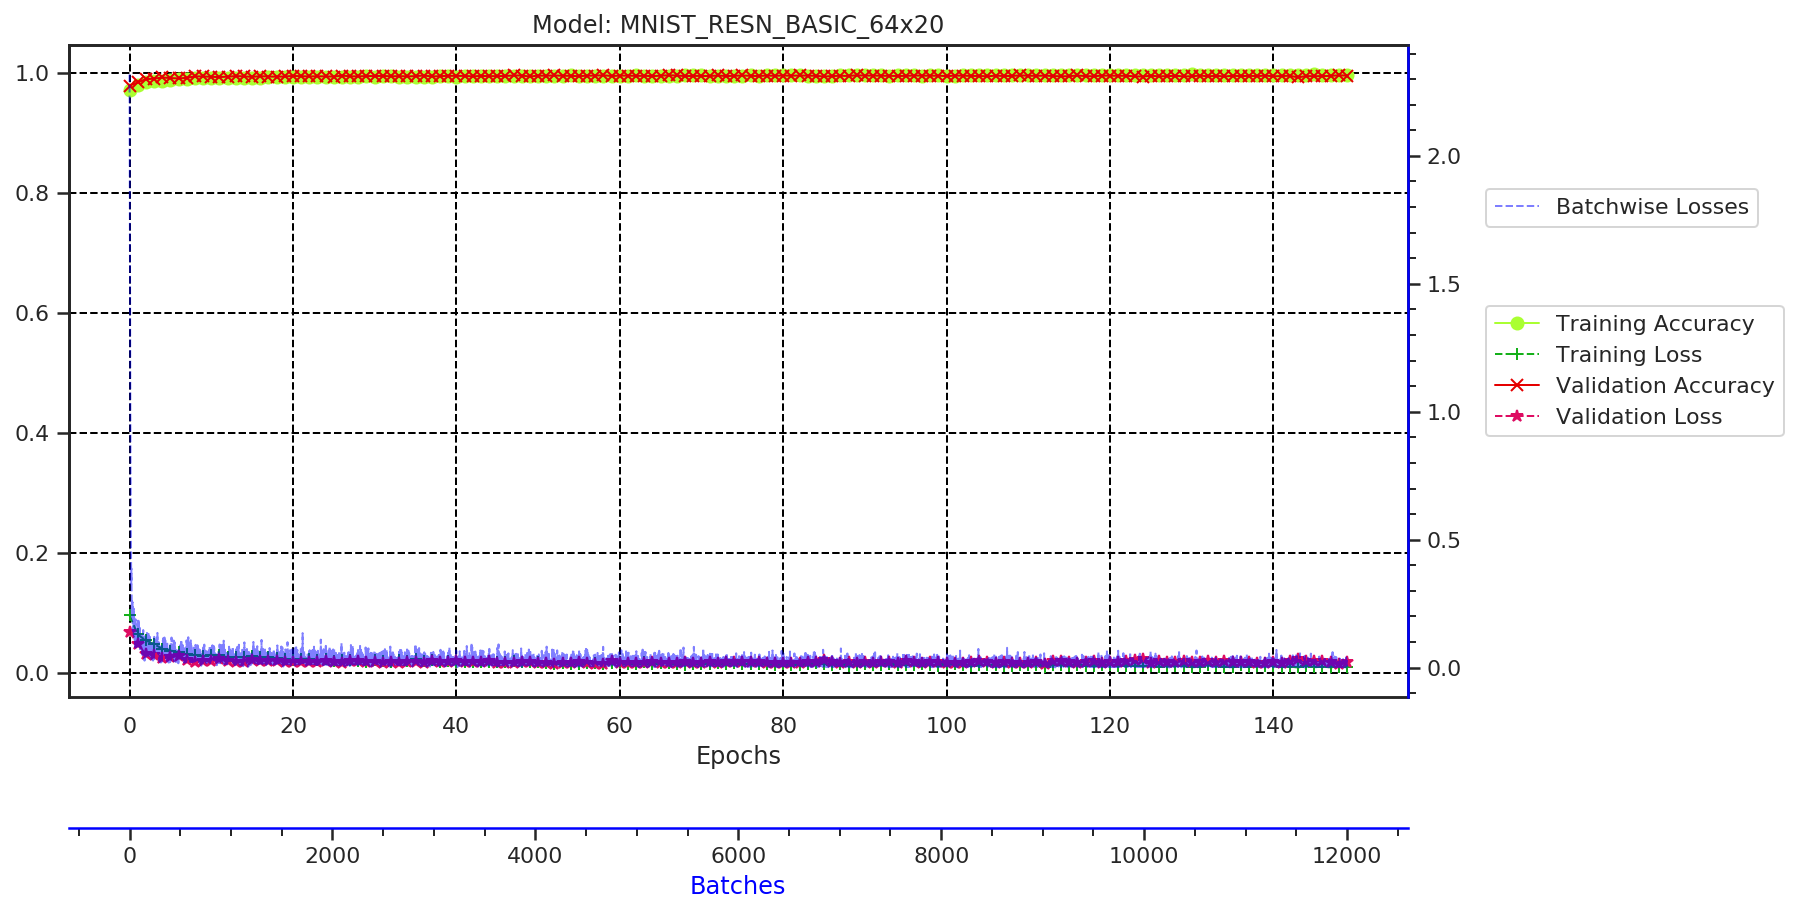

In [22]:
# 5
trainer_dict[5].lr = 0.0001
trainer_dict[5](150, log_interval=1)
trainer_dict[5].plot()

## Ensemble predictors and predict for testset

In [23]:
ensemble_models = []

for key in trainer_dict.keys():
    trainer_dict[key].loadstate(True)
    ensemble_models.append(trainer_dict[key].model)
    

file ./saves/MNIST_RESN_BNECK_64x11_best.pth found
file ./saves/MNIST_RESN_BNECK_48x29_best.pth found
file ./saves/MNIST_RESN_BASIC_64x8_best.pth found
file ./saves/MNIST_RESN_BASIC_64x14_best.pth found
file ./saves/MNIST_RESN_BASIC_64x20_best.pth found


In [ ]:
# test
trainer_dict[1].loadstate(True)
predmodel = trainer_dict[1].model
predopt = trainer_dict[1].optimizer

In [24]:
def to_np(v):
    if isinstance(v, (np.ndarray, np.generic)): return v
    if isinstance(v, (list,tuple)): return [to_np(o) for o in v]
    if isinstance(v, Variable): v=v.data
    if tc.cuda.is_available():
        if isinstance(v, tc.cuda.HalfTensor): v=v.float()
    if isinstance(v, tc.FloatTensor): v=v.float()
    return v.cpu().numpy()


def predict(models, testloader, test_set=TestSet):
    
    gc.collect()
    tc.cuda.empty_cache()
    [model.eval() for model in models]
    
    target = np.zeros(len(test_set)).astype(np.int8)
    
    for idx, img in enumerate(testloader):
        batch_size = len(img)
        img = img.to('cuda',dtype=tc.float,
                     non_blocking=True,copy=False)
        output = np.zeros((batch_size, 10), dtype='float32')
        for _modl in models:
            output += to_np(_modl.forward(img))
        
        target[idx:idx+batch_size] = np.argmax(output, -1)
    return target

In [25]:
predictions = predict(ensemble_models, NN_testloader, TestSet)
predictions[0:10]

array([2, 0, 9, 0, 3, 7, 0, 3, 0, 3], dtype=int8)

In [26]:
np.unique(y_train, return_counts=True), np.unique(predictions, return_counts=True)

((array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
  array([3321, 3748, 3339, 3445, 3251, 3063, 3268, 3545, 3260, 3360])),
 (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8),
  array([2769, 3186, 2817, 2794, 2754, 2510, 2750, 2891, 2757, 2772])))

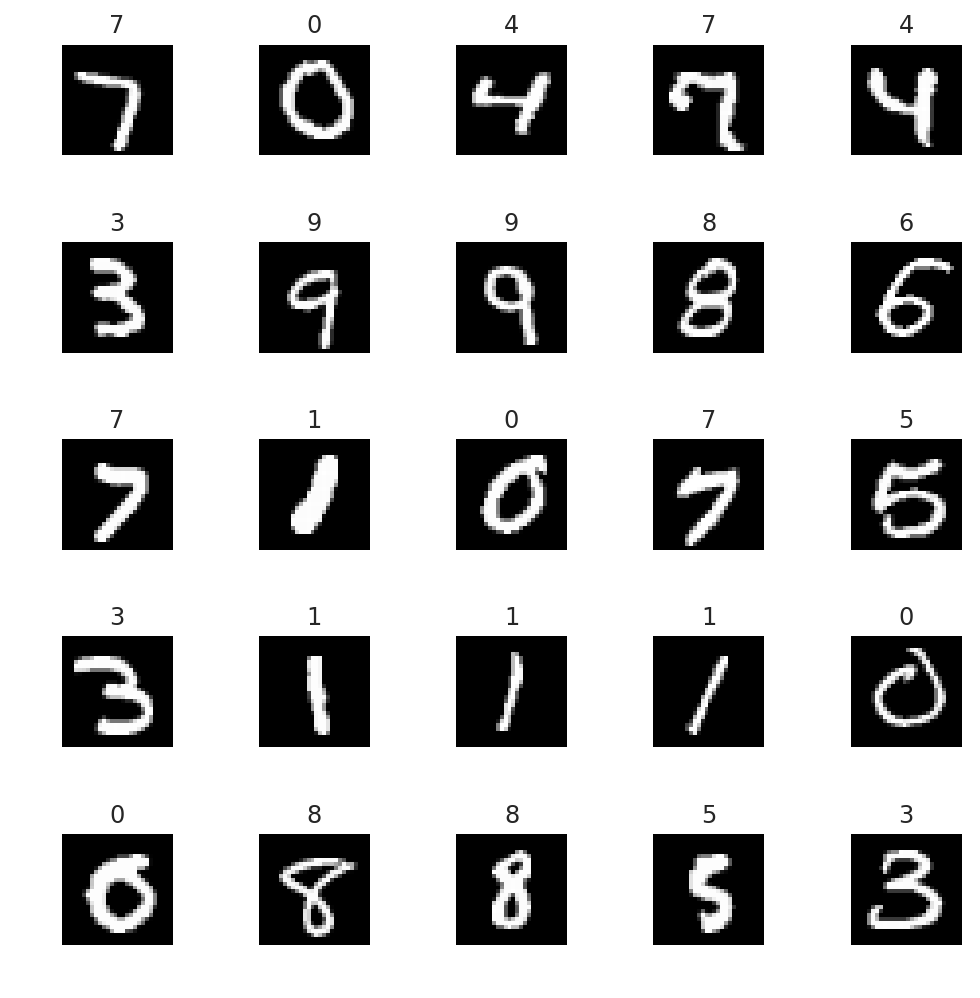

In [29]:
fig, axes = plt.subplots(5, 5, figsize=(7, 7))

for ax_ in axes:
    for _ax in ax_:
        numsample = np.random.randint(0, len(x_test))
        _ = _ax.imshow(x_test[numsample], cmap='gray')
        _ = _ax.set_title(f'{predictions[numsample]}')
        _ = _ax.set_axis_off()

plt.subplots_adjust(hspace=0.1)
plt.tight_layout()
plt.show()

In [33]:
with open('./saves/MNIST_saved_results.npy','wb') as file:
    pickle.dump(predictions, file, protocol=-1)
    file.close()
    
df = pd.DataFrame(predictions, columns=['Label'])
df.index.name = 'ImageId'
df.index += 1
df.to_csv("./saves/MNIST_results.csv")
df.head()

,Label
ImageId,
1,2
2,0
3,9
4,0
5,3
